# K-Means Clustering Mall Customers

In [15]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import plotly.graph_objects as go
import os

# Create outputs directory if it doesn't exist
os.makedirs('outputs', exist_ok=True)

# Load the dataset
dataset = pd.read_csv('raw_data/Mall_Customers.csv')

# Data Preprocessing
# Convert Genre to numeric
dataset['Genre'] = np.where(dataset['Genre'] == 'Male', 0, 1)

# Function to perform K-means clustering and return results
def perform_kmeans(X, n_clusters):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42, n_init=10)
    y_kmeans = kmeans.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, y_kmeans)
    return kmeans, y_kmeans, silhouette_avg, X_scaled

# Function to plot elbow method
def plot_elbow_method(X, max_clusters=10, title='Elbow Method'):
    wcss = []
    for i in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10)
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_clusters + 1), wcss, marker='o')
    plt.title(f"{title} ({X.shape[1]}D)", fontsize=20)
    plt.xlabel('Number of Clusters', fontsize=14)
    plt.ylabel('WCSS', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.savefig(f'outputs/{title.lower().replace(" ", "_")}_{X.shape[1]}d.png', dpi=300, bbox_inches='tight')
    plt.show()

# Function to plot silhouette analysis
def plot_silhouette_analysis(X, max_clusters=10, title='Silhouette Analysis'):
    print(f"Input data shape for {title}: {X.shape}")  # Print input data shape
    
    silhouette_scores = []
    for n_clusters in range(2, max_clusters + 1):
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)  # Scale the data
        clusterer = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        cluster_labels = clusterer.fit_predict(X_scaled)
        silhouette_avg = silhouette_score(X_scaled, cluster_labels)
        silhouette_scores.append(silhouette_avg)
        print(f"For n_clusters = {n_clusters}, the average silhouette score is : {silhouette_avg:.3f}")
    
    plt.figure(figsize=(10, 6))  # Create a new figure for each plot
    plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
    plt.title(title, fontsize=20)  # Keeping the original title format
    plt.xlabel('Number of Clusters', fontsize=14)
    plt.ylabel('Silhouette Score', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.savefig(f'outputs/{title.lower().replace(" ", "_")}.png', dpi=300, bbox_inches='tight')
    plt.close()  # Close the figure to ensure it's saved properly
    
    return silhouette_scores  # Return the scores for further analysis

# Create summary tables function
def create_summary_table(dataset, y_kmeans, features):
    dataset['Cluster'] = y_kmeans
    
    def cluster_summary(cluster_data):
        summary = {'Size': len(cluster_data)}
        
        if 'Genre' in features:
            summary['Male %'] = (cluster_data['Genre'] == 0).mean() * 100
            summary['Female %'] = (cluster_data['Genre'] == 1).mean() * 100
        
        for feature in features:
            if feature != 'Genre':
                summary[f'{feature} (Mean)'] = cluster_data[feature].mean()
                summary[f'{feature} (Median)'] = cluster_data[feature].median()
        
        return pd.Series(summary)

    cluster_summaries = dataset.groupby('Cluster').apply(cluster_summary).reset_index()
    cluster_summaries = cluster_summaries.sort_values('Cluster')
    
    # Define column order based on features
    column_order = ['Cluster', 'Size']
    if 'Genre' in features:
        column_order.extend(['Male %', 'Female %'])
    for feature in features:
        if feature != 'Genre':
            column_order.extend([f'{feature} (Mean)', f'{feature} (Median)'])
    
    cluster_summaries = cluster_summaries[column_order]
    
    # Apply styling to the dataframe
    style_format = {
        'Size': '{:,.0f}',
        'Male %': '{:.1f}%',
        'Female %': '{:.1f}%',
        'Age (Mean)': '{:.1f}',
        'Age (Median)': '{:.1f}',
        'Annual Income (k$) (Mean)': '${:,.0f}k',
        'Annual Income (k$) (Median)': '${:,.0f}k',
        'Spending Score (1-100) (Mean)': '{:.1f}',
        'Spending Score (1-100) (Median)': '{:.1f}'
    }
    
    styled_df = cluster_summaries.style.format(style_format)
    
    styled_df = styled_df.background_gradient(subset=['Size'], cmap='Blues')
    
    if 'Genre' in features:
        styled_df = styled_df.background_gradient(subset=['Male %', 'Female %'], cmap='RdYlGn')
    
    for feature in features:
        if feature != 'Genre':
            styled_df = styled_df.background_gradient(
                subset=[f'{feature} (Mean)', f'{feature} (Median)'],
                cmap='YlOrRd' if feature == 'Age' else 'Greens' if feature == 'Annual Income (k$)' else 'PuBu'
            )
    
    styled_df = styled_df.set_properties(**{'text-align': 'center'})\
        .set_table_styles([
            {'selector': 'th', 'props': [('background-color', '#f2f2f2'), ('color', 'black'), ('font-weight', 'bold')]},
            {'selector': 'td', 'props': [('padding', '8px')]},
            {'selector': '', 'props': [('border-collapse', 'collapse'), ('border', '1px solid #ddd')]}
        ])
    
    return styled_df

## 2D clustering (Annual Income, Spending Score)

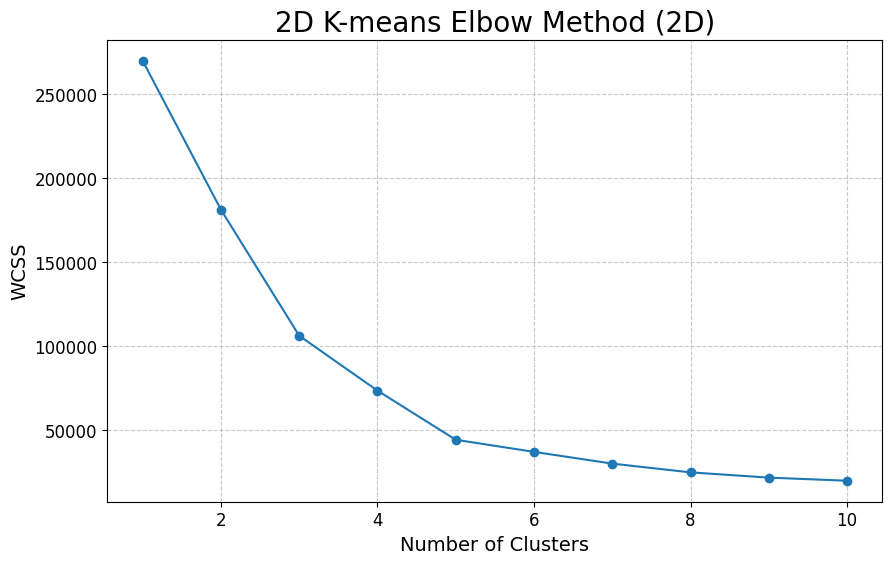

Input data shape for 2D K-means Silhouette Analysis: (200, 2)
For n_clusters = 2, the average silhouette score is : 0.321
For n_clusters = 3, the average silhouette score is : 0.467
For n_clusters = 4, the average silhouette score is : 0.494
For n_clusters = 5, the average silhouette score is : 0.555
For n_clusters = 6, the average silhouette score is : 0.540
For n_clusters = 7, the average silhouette score is : 0.528
For n_clusters = 8, the average silhouette score is : 0.455
For n_clusters = 9, the average silhouette score is : 0.457
For n_clusters = 10, the average silhouette score is : 0.443


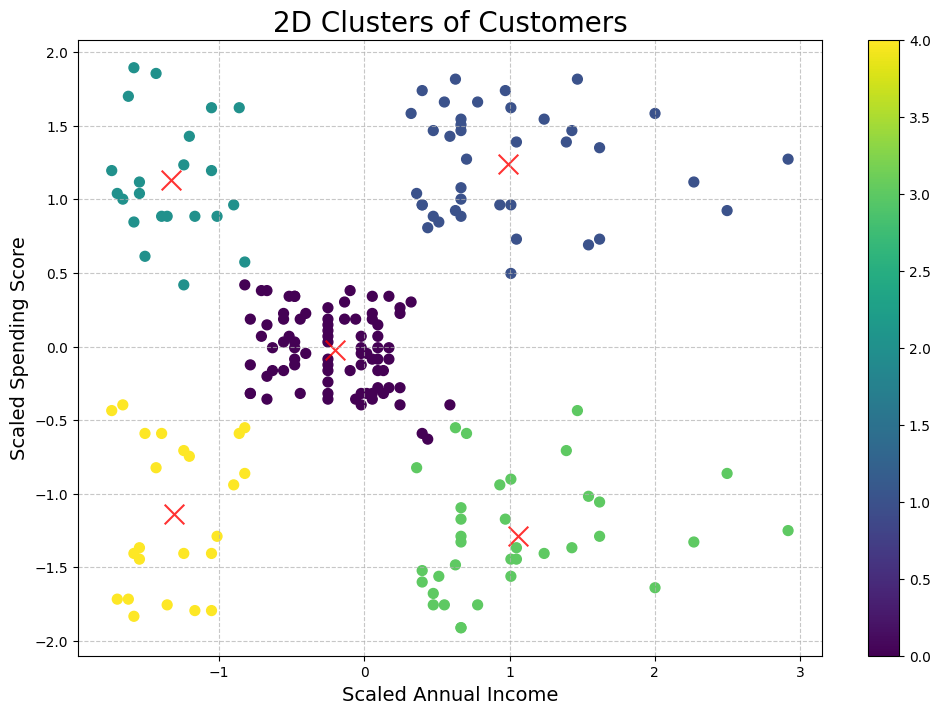

/tmp/ipykernel_81741/2209986100.py:95: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cluster_summaries = dataset.groupby('Cluster').apply(cluster_summary).reset_index()


In [2]:
# 2D K-means Clustering
X_2d = dataset.iloc[:, [3, 4]].values
plot_elbow_method(X_2d, title='2D K-means Elbow Method')
plot_silhouette_analysis(X_2d, title='2D K-means Silhouette Analysis')

kmeans_2d, y_kmeans_2d, silhouette_2d, X_scaled_2d = perform_kmeans(X_2d, n_clusters=5)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_scaled_2d[:, 0], X_scaled_2d[:, 1], c=y_kmeans_2d, s=50, cmap='viridis')
centers = kmeans_2d.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.8, marker='x')
plt.title('2D Clusters of Customers', fontsize=20)
plt.xlabel('Scaled Annual Income', fontsize=14)
plt.ylabel('Scaled Spending Score', fontsize=14)
plt.colorbar(scatter)
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('outputs/2d_clusters.png', dpi=300, bbox_inches='tight')
plt.show()

styled_df_2d = create_summary_table(dataset, y_kmeans_2d, ['Annual Income (k$)', 'Spending Score (1-100)'])
display(styled_df_2d)
styled_df_2d.to_html('outputs/2d_summary_table.html')

## 3D Clustering (Age, Annual Income, Spending score)

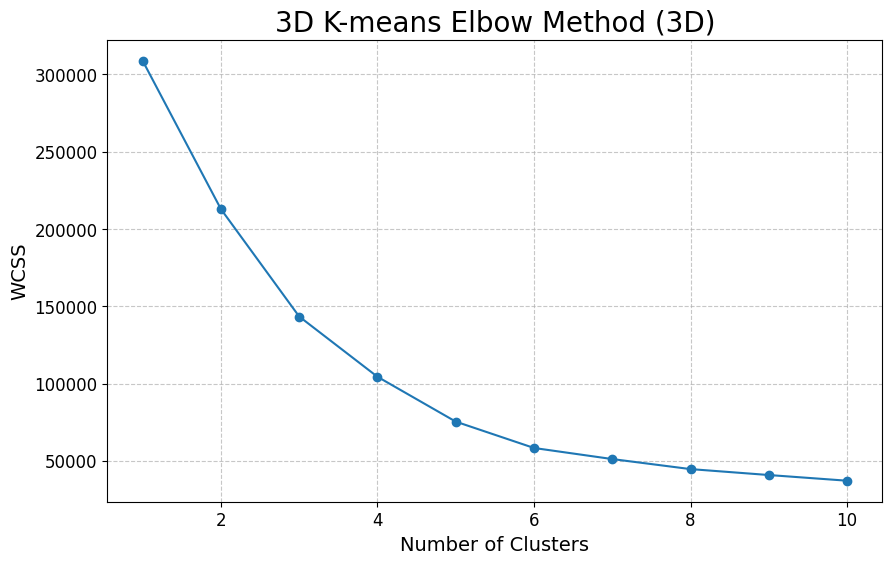

Input data shape for 3D K-means Silhouette Analysis: (200, 3)
For n_clusters = 2, the average silhouette score is : 0.335
For n_clusters = 3, the average silhouette score is : 0.358
For n_clusters = 4, the average silhouette score is : 0.404
For n_clusters = 5, the average silhouette score is : 0.417
For n_clusters = 6, the average silhouette score is : 0.428
For n_clusters = 7, the average silhouette score is : 0.417
For n_clusters = 8, the average silhouette score is : 0.408
For n_clusters = 9, the average silhouette score is : 0.418
For n_clusters = 10, the average silhouette score is : 0.407


/tmp/ipykernel_81741/2209986100.py:95: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [3]:
# 3D K-means Clustering
X_3d = dataset.iloc[:, [2, 3, 4]].values
plot_elbow_method(X_3d, title='3D K-means Elbow Method')
plot_silhouette_analysis(X_3d, title='3D K-means Silhouette Analysis')

kmeans_3d, y_kmeans_3d, silhouette_3d, X_scaled_3d = perform_kmeans(X_3d, n_clusters=6)

fig = go.Figure(data=[go.Scatter3d(
    x=X_scaled_3d[:, 0],
    y=X_scaled_3d[:, 1],
    z=X_scaled_3d[:, 2],
    mode='markers',
    marker=dict(
        size=5,
        color=y_kmeans_3d,
        colorscale='Viridis',
        opacity=0.8
    ),
    text=[f"Age: {dataset['Age'][i]}<br>Annual Income: {dataset['Annual Income (k$)'][i]}<br>Spending Score: {dataset['Spending Score (1-100)'][i]}" for i in range(len(dataset))],
    hoverinfo='text'
)])

centers = kmeans_3d.cluster_centers_
fig.add_trace(go.Scatter3d(
    x=centers[:, 0],
    y=centers[:, 1],
    z=centers[:, 2],
    mode='markers',
    marker=dict(
        color='red',
        size=10,
        symbol='x'
    ),
    name='Cluster Centers'
))

fig.update_layout(
    title='3D Clusters of Customers',
    scene=dict(
        xaxis_title='Scaled Age',
        yaxis_title='Scaled Annual Income',
        zaxis_title='Scaled Spending Score'
    ),
    width=900,
    height=700,
)

fig.write_html("outputs/3d_clusters_interactive.html")
fig.show()

styled_df_3d = create_summary_table(dataset, y_kmeans_3d, ['Age', 'Annual Income (k$)', 'Spending Score (1-100)'])
display(styled_df_3d)
styled_df_3d.to_html('outputs/3d_summary_table.html')

## 4D Clustering (Genre, Age, Annual Income, Spending score)

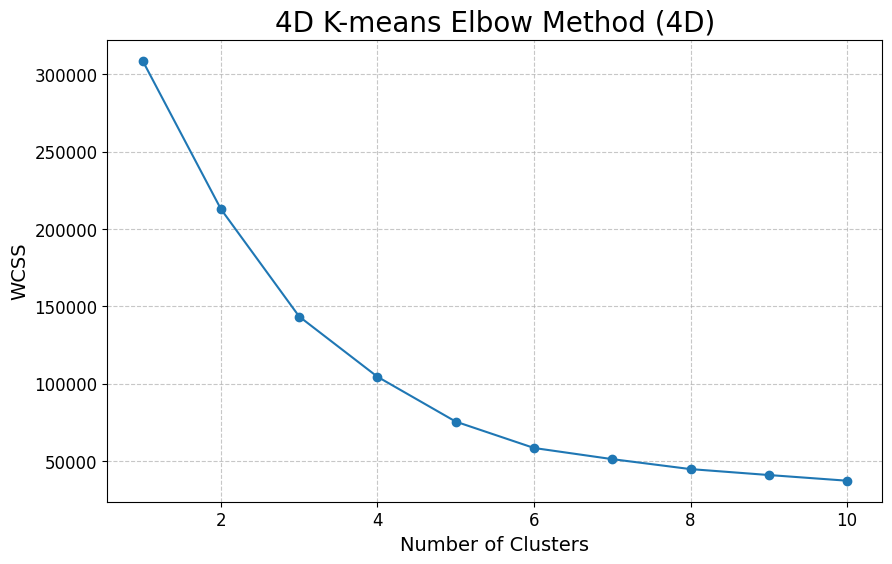

Input data shape for 4D K-means Silhouette Analysis: (200, 4)
For n_clusters = 2, the average silhouette score is : 0.252
For n_clusters = 3, the average silhouette score is : 0.260
For n_clusters = 4, the average silhouette score is : 0.298
For n_clusters = 5, the average silhouette score is : 0.304
For n_clusters = 6, the average silhouette score is : 0.331
For n_clusters = 7, the average silhouette score is : 0.357
For n_clusters = 8, the average silhouette score is : 0.388
For n_clusters = 9, the average silhouette score is : 0.403
For n_clusters = 10, the average silhouette score is : 0.421


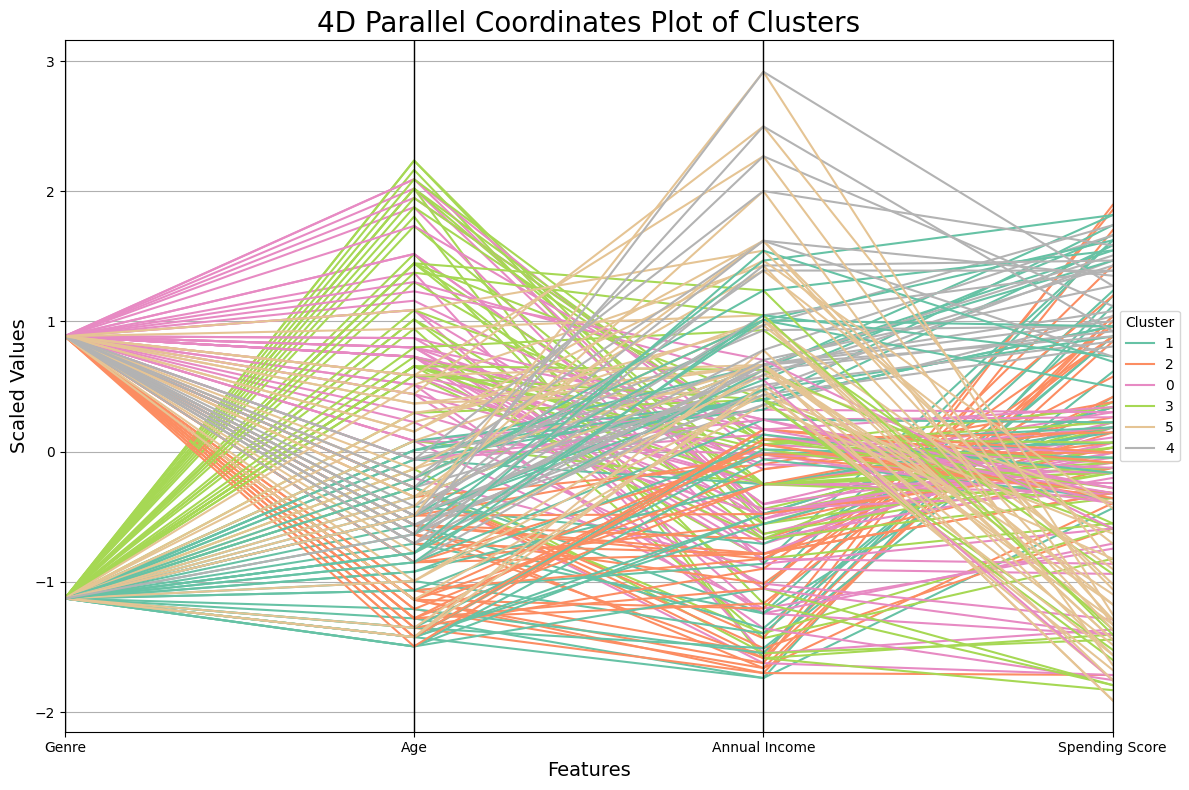

/tmp/ipykernel_81741/2209986100.py:95: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.




4D Silhouette Scores:
Clusters: 2, Score: 0.2518
Clusters: 3, Score: 0.2595
Clusters: 4, Score: 0.2984
Clusters: 5, Score: 0.3041
Clusters: 6, Score: 0.3311
Clusters: 7, Score: 0.3574
Clusters: 8, Score: 0.3880
Clusters: 9, Score: 0.4031
Clusters: 10, Score: 0.4208


In [16]:
# 4D K-means Clustering
X_4d = dataset.iloc[:, [1, 2, 3, 4]].values
plot_elbow_method(X_4d, title='4D K-means Elbow Method')
silhouette_scores_4d = plot_silhouette_analysis(X_4d, title='4D K-means Silhouette Analysis')

kmeans_4d, y_kmeans_4d, silhouette_4d, X_scaled_4d = perform_kmeans(X_4d, n_clusters=6)

plt.figure(figsize=(12, 8))
pd.plotting.parallel_coordinates(
    pd.DataFrame(X_scaled_4d, columns=['Genre', 'Age', 'Annual Income', 'Spending Score']).assign(Cluster=y_kmeans_4d),
    'Cluster',
    colormap=plt.cm.Set2
)
plt.title('4D Parallel Coordinates Plot of Clusters', fontsize=20)
plt.xlabel('Features', fontsize=14)
plt.ylabel('Scaled Values', fontsize=14)
plt.legend(title='Cluster', loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig('outputs/4d_parallel_coordinates.png', dpi=300, bbox_inches='tight')
plt.show()

styled_df_4d = create_summary_table(dataset, y_kmeans_4d, ['Genre', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)'])
display(styled_df_4d)
styled_df_4d.to_html('outputs/4d_summary_table.html')

# Print silhouette scores for different number of clusters
print("\n4D Silhouette Scores:")
for i, score in enumerate(silhouette_scores_4d, start=2):
    print(f"Clusters: {i}, Score: {score:.4f}")

## Comparison of clustering approaches

Comparison of K-means Clustering Results:
Dimensions                                  Features  Number of Clusters  Silhouette Score    Inertia
        2D             Annual Income, Spending Score                   5          0.554657  65.568408
        3D        Age, Annual Income, Spending Score                   6          0.428417 133.868421
        4D Genre, Age, Annual Income, Spending Score                   6          0.331074 276.411760


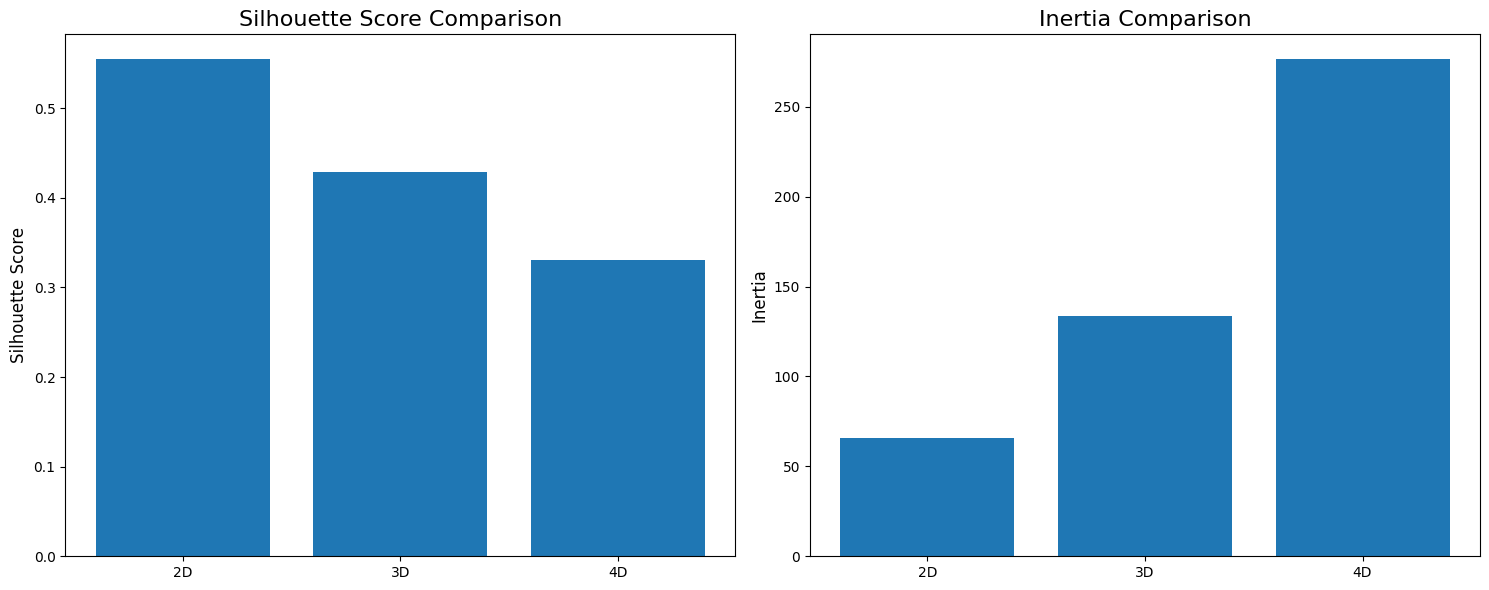

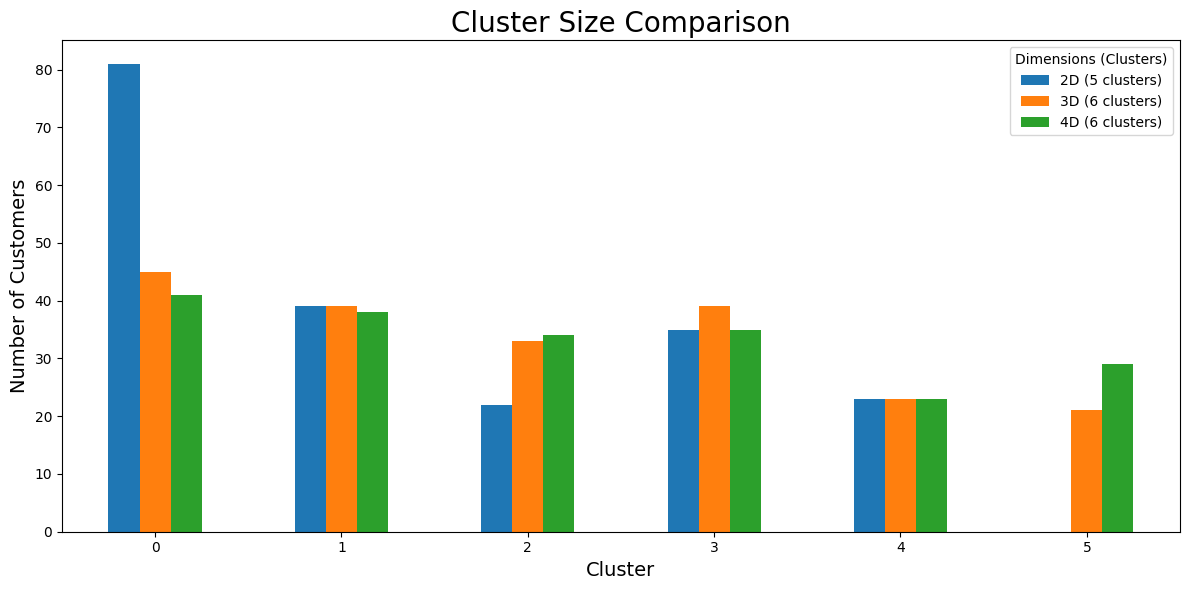

In [5]:
# Comparison of 2D, 3D, and 4D clustering
comparison = pd.DataFrame({
    'Dimensions': ['2D', '3D', '4D'],
    'Features': ['Annual Income, Spending Score', 
                 'Age, Annual Income, Spending Score',
                 'Genre, Age, Annual Income, Spending Score'],
    'Number of Clusters': [5, 6, 6],
    'Silhouette Score': [silhouette_2d, silhouette_3d, silhouette_4d],
    'Inertia': [kmeans_2d.inertia_, kmeans_3d.inertia_, kmeans_4d.inertia_]
})

print("Comparison of K-means Clustering Results:")
print(comparison.to_string(index=False))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.bar(comparison['Dimensions'], comparison['Silhouette Score'])
ax1.set_title('Silhouette Score Comparison', fontsize=16)
ax1.set_ylabel('Silhouette Score', fontsize=12)
ax1.tick_params(axis='both', which='major', labelsize=10)

ax2.bar(comparison['Dimensions'], comparison['Inertia'])
ax2.set_title('Inertia Comparison', fontsize=16)
ax2.set_ylabel('Inertia', fontsize=12)
ax2.tick_params(axis='both', which='major', labelsize=10)

plt.tight_layout()
plt.savefig('outputs/kmeans_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Compare cluster distributions
cluster_sizes = pd.DataFrame({
    '2D (5 clusters)': pd.Series(y_kmeans_2d).value_counts().sort_index(),
    '3D (6 clusters)': pd.Series(y_kmeans_3d).value_counts().sort_index(),
    '4D (6 clusters)': pd.Series(y_kmeans_4d).value_counts().sort_index()
})

cluster_sizes.plot(kind='bar', figsize=(12, 6))
plt.title('Cluster Size Comparison', fontsize=20)
plt.xlabel('Cluster', fontsize=14)
plt.ylabel('Number of Customers', fontsize=14)
plt.legend(title='Dimensions (Clusters)')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('outputs/cluster_size_comparison.png', dpi=300, bbox_inches='tight')
plt.show()